In [22]:
!pip install opencv-python mediapipe matplotlib scikit-learn numpy IPython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00


In [23]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import pickle
import random
from sklearn.ensemble import RandomForestClassifier
import time
import os

In [75]:
# Cell 3: Setup webcam access in Colab
# --------------------------------
def take_photo(filename='photo.jpg', quality=0.8):
    """Use JavaScript to capture an image from the webcam in Google Colab."""
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const video = document.createElement('video');
      const canvas = document.createElement('canvas');

      div.style.textAlign = 'center';
      div.style.marginTop = '20px';
      video.style.display = 'block';
      video.style.margin = '0 auto';
      video.style.border = '1px solid black';
      video.style.transform = 'scaleX(-1)'; // Mirror image horizontally
      capture.textContent = 'Capture';
      capture.style.display = 'block';
      capture.style.margin = '10px auto';
      capture.style.padding = '10px 20px';
      capture.style.backgroundColor = '#4CAF50';
      capture.style.color = 'white';
      capture.style.border = 'none';
      capture.style.borderRadius = '5px';
      capture.style.fontSize = '16px';
      capture.style.cursor = 'pointer';

      div.appendChild(video);
      div.appendChild(capture);
      document.body.appendChild(div);

      const constraints = {
        video: {
          facingMode: "user",
          width: { ideal: 640 },
          height: { ideal: 480 }
        }
      };

      const stream = await navigator.mediaDevices.getUserMedia(constraints);
      video.srcObject = stream;
      video.play();

      return new Promise((resolve) => {
        capture.onclick = () => {
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          resolve(canvas.toDataURL('image/jpeg', quality));
        };
      });
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [76]:
# Cell 4: Setup hand tracking with MediaPipe
# --------------------------------
class HandTracker:
    """Tracks hand landmarks using MediaPipe Hands."""

    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles

    def detect_landmarks(self, image):
        """Detect hand landmarks in the image."""
        # Convert the BGR image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image and detect hands
        results = self.hands.process(image_rgb)

        return results

    def draw_landmarks(self, image, results):
        """Draw the detected landmarks on the image."""
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                self.mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    self.mp_hands.HAND_CONNECTIONS,
                    self.mp_drawing_styles.get_default_hand_landmarks_style(),
                    self.mp_drawing_styles.get_default_hand_connections_style())
        return image

    def get_landmark_coordinates(self, results):
        """Extract normalized coordinates of hand landmarks."""
        if not results.multi_hand_landmarks:
            return None

        # Get the first detected hand
        hand_landmarks = results.multi_hand_landmarks[0]

        # Extract coordinates for each landmark
        landmarks = []
        for landmark in hand_landmarks.landmark:
            # Keep normalized coordinates (they work better for recognition)
            x = landmark.x
            y = landmark.y
            z = landmark.z
            landmarks.append([x, y, z])

        return np.array(landmarks)

    def extract_features(self, landmarks):
        """Extract hand gesture features from landmarks for classification."""
        if landmarks is None:
            return None

        # Flatten the landmarks array for ML model input
        flattened = landmarks.flatten()

        # Calculate additional features (optional but helpful)
        features = []
        features.extend(flattened)  # Add all landmark coordinates

        # Normalize relative to wrist position
        wrist = landmarks[0]
        for i in range(1, 21):  # 21 landmarks total
            # Add distance from wrist to each landmark
            dist = np.sqrt(
                (landmarks[i][0] - wrist[0])**2 +
                (landmarks[i][1] - wrist[1])**2
            )
            features.append(dist)

        # Calculate angles between key finger joints
        # Thumb: 1-4, Index: 5-8, Middle: 9-12, Ring: 13-16, Pinky: 17-20

        # Calculate finger extensions
        thumb_ext = self._calculate_extension(landmarks, 1, 2, 3, 4)
        index_ext = self._calculate_extension(landmarks, 5, 6, 7, 8)
        middle_ext = self._calculate_extension(landmarks, 9, 10, 11, 12)
        ring_ext = self._calculate_extension(landmarks, 13, 14, 15, 16)
        pinky_ext = self._calculate_extension(landmarks, 17, 18, 19, 20)

        features.extend([thumb_ext, index_ext, middle_ext, ring_ext, pinky_ext])

        return np.array(features)

    def _calculate_extension(self, landmarks, base_idx, mid1_idx, mid2_idx, tip_idx):
        """Calculate how extended a finger is (1.0 = fully extended, 0.0 = curled)"""
        # Vector from base to tip
        base_to_tip_x = landmarks[tip_idx][0] - landmarks[base_idx][0]
        base_to_tip_y = landmarks[tip_idx][1] - landmarks[base_idx][1]
        base_to_tip_len = np.sqrt(base_to_tip_x**2 + base_to_tip_y**2)

        # Length of each segment
        seg1_len = np.sqrt((landmarks[mid1_idx][0] - landmarks[base_idx][0])**2 +
                          (landmarks[mid1_idx][1] - landmarks[base_idx][1])**2)
        seg2_len = np.sqrt((landmarks[mid2_idx][0] - landmarks[mid1_idx][0])**2 +
                          (landmarks[mid2_idx][1] - landmarks[mid1_idx][1])**2)
        seg3_len = np.sqrt((landmarks[tip_idx][0] - landmarks[mid2_idx][0])**2 +
                          (landmarks[tip_idx][1] - landmarks[mid2_idx][1])**2)

        # Total length if fully extended
        total_seg_len = seg1_len + seg2_len + seg3_len

        # Ratio between direct distance and summed segment lengths
        if total_seg_len > 0:
            extension = base_to_tip_len / total_seg_len
        else:
            extension = 0

        return min(1.0, max(0.0, extension))  # Clamp between 0 and 1

In [77]:
# Cell 5: Model Training and Recognition
# --------------------------------
class SignLanguageRecognizer:
    """Recognizes sign language numbers using a trained ML model."""

    def __init__(self):
        self.hand_tracker = HandTracker()
        self.model = None
        self.trained = False

    def collect_training_data(self, num_samples=5):
        """Collect training data for each number (0, 1, 2)."""
        X = []  # Features
        y = []  # Labels

        for number in range(3):  # 0, 1, 2
            print(f"\n{'='*60}")
            print(f"Collecting samples for number {number}".center(60))
            print(f"{'='*60}")

            # Show reference for the ASL number
            self._display_asl_reference(number)

            print(f"\nWe'll collect {num_samples} samples for the number {number}.")

            for i in range(num_samples):
                print(f"\nCapturing sample {i+1}/{num_samples} for number {number}")
                print("Please show the ASL sign for number", number)
                print("Click 'Capture' when ready.")

                # Take photo
                filename = take_photo()

                # Load image
                image = cv2.imread(filename)

                # Detect hand landmarks
                results = self.hand_tracker.detect_landmarks(image)

                # Draw landmarks on the image
                image_with_landmarks = self.hand_tracker.draw_landmarks(image.copy(), results)

                # Display the image with landmarks
                plt.figure(figsize=(6, 4))
                plt.imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
                plt.title(f"Sample {i+1} for number {number}")
                plt.axis('off')
                plt.show()

                # Extract landmarks
                landmarks = self.hand_tracker.get_landmark_coordinates(results)

                if landmarks is not None:
                    # Extract features for ML model
                    features = self.hand_tracker.extract_features(landmarks)

                    # Add to training data
                    X.append(features)
                    y.append(number)

                    print("✅ Sample captured successfully")
                else:
                    print("❌ No hand detected. Please try again.")
                    i -= 1  # Try again

                time.sleep(1)  # Short pause between samples

        return np.array(X), np.array(y)

    def train_model(self, X, y):
        """Train a machine learning model on the collected data."""
        print("\nTraining model...")

        # Initialize and train a Random Forest classifier
        # This is a good choice for small datasets
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X, y)

        self.model = model
        self.trained = True

        print("✅ Model trained successfully!")
        return model

    def recognize_sign(self, image=None, results=None):
        """Recognize the ASL number sign in an image."""
        if not self.trained:
            return {"recognized_number": None, "confidence": 0, "error": "Model not trained"}

        # If image is provided, detect landmarks
        if image is not None:
            results = self.hand_tracker.detect_landmarks(image)

        # Extract landmarks and features
        landmarks = self.hand_tracker.get_landmark_coordinates(results)

        if landmarks is None:
            return {"recognized_number": None, "confidence": 0, "error": "No hand detected"}

        # Extract features
        features = self.hand_tracker.extract_features(landmarks)

        # Predict using the trained model
        prediction = self.model.predict([features])[0]

        # Get prediction probabilities
        proba = self.model.predict_proba([features])[0]
        confidence = proba[prediction]

        return {
            "recognized_number": int(prediction),
            "confidence": float(confidence),
            "explanation": f"Detected ASL sign for number {prediction}"
        }

    def save_model(self, filename="asl_number_model.pkl"):
        """Save the trained model to disk."""
        if not self.trained:
            print("⚠️ No trained model to save")
            return False

        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)

        print(f"✅ Model saved to {filename}")
        return True

    def load_model(self, filename="asl_number_model.pkl"):
        """Load a trained model from disk."""
        try:
            with open(filename, 'rb') as f:
                self.model = pickle.load(f)

            self.trained = True
            print(f"✅ Model loaded from {filename}")
            return True
        except FileNotFoundError:
            print(f"❌ Model file {filename} not found")
            return False
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            return False

    def _display_asl_reference(self, number):
        """Display reference for ASL number signs."""
        print(f"\n📚 ASL Number Sign Reference for {number}:")

        if number == 0:
            print("0️⃣: Make a closed fist with thumb alongside fingers (like the letter 'O').")
            print("   Close all fingers making an 'O' shape.")
        elif number == 1:
            print("1️⃣: Point your index finger up with all other fingers closed.")
            print("   Only extend your index finger, keep all other fingers closed.")
        elif number == 2:
            print("2️⃣: Extend your index and middle fingers in a 'V' shape.")
            print("   Keep your ring and pinky fingers closed, thumb tucked or extended.")

In [78]:
# Cell 6: Quiz System Implementation
# --------------------------------
class EduSignQuizSystem:
    """Quiz system for sign language recognition."""

    def __init__(self):
        self.recognizer = SignLanguageRecognizer()
        self.current_question = None
        self.questions = [
            {"question": "How many eyes does a person have?", "answer": 2, "explanation": "People have two eyes for binocular vision."},
            {"question": "How many noses does a person have?", "answer": 1, "explanation": "People have one nose for breathing and smelling."},
            {"question": "What is 1 + 1?", "answer": 2, "explanation": "One plus one equals two."},
            {"question": "What is 2 + 0?", "answer": 2, "explanation": "Two plus zero equals two."},
            {"question": "What is 2 - 1?", "answer": 1, "explanation": "Two minus one equals one."},
            {"question": "What is 1 + 0?", "answer": 1, "explanation": "One plus zero equals one."},
            {"question": "What is the smallest single-digit number?", "answer": 0, "explanation": "Zero is the smallest single-digit number."},
            {"question": "How many thumbs do you have on one hand?", "answer": 1, "explanation": "Each hand has one thumb."},
            {"question": "What is 1 - 1?", "answer": 0, "explanation": "One minus one equals zero."}
        ]

    def display_welcome_message(self):
        """Display welcome message and instructions."""
        print("\n" + "="*60)
        print("🎓 Welcome to EduSign AI Quiz System! 🎓".center(60))
        print("Sign Language Recognition for Deaf and Hard-of-Hearing Students".center(60))
        print("="*60 + "\n")

        print("This system will test your sign language skills for numbers 0, 1, and 2.")
        print("First, we need to train the system to recognize your specific hand signs.")
        print("Then, you'll be shown questions, and you'll need to show the answer")
        print("using American Sign Language (ASL) to the webcam.\n")

    def setup_system(self):
        """Set up the system by training or loading the recognition model."""
        self.display_welcome_message()

        # Check if we should train a new model or use existing one
        load_existing = False
        if os.path.exists("asl_number_model.pkl"):
            response = input("An existing model was found. Would you like to use it? (yes/no): ").lower()
            load_existing = response == "yes" or response == "y"

        if load_existing:
            # Load existing model
            self.recognizer.load_model()
        else:
            # Collect training data and train model
            print("\nLet's train the system to recognize your ASL number signs (0, 1, 2).")
            print("We'll need to collect a few samples of each sign.\n")

            num_samples = 5
            try:
                user_samples = input(f"How many samples for each number? (default: {num_samples}): ")
                if user_samples.strip():
                    num_samples = int(user_samples)
            except:
                # Keep default if invalid input
                pass

            # Collect training data
            X, y = self.recognizer.collect_training_data(num_samples)

            # Train model
            self.recognizer.train_model(X, y)

            # Save model for future use
            self.recognizer.save_model()

    def generate_question(self):
        """Generate a random question for the quiz."""
        self.current_question = random.choice(self.questions)
        return self.current_question

    def display_question(self):
        """Display the current quiz question."""
        if not self.current_question:
            self.generate_question()

        print("\n" + "-"*60)
        print(f"📝 Question: {self.current_question['question']}")
        print(f"Please show the answer (0, 1, or 2) in ASL sign language.")
        print("-"*60)

    def capture_and_recognize_sign(self):
        """Capture image from webcam and recognize the sign."""
        print("\nPlease position your hand to show the answer in ASL.")
        print("Click 'Capture' when ready.\n")

        # Capture photo from webcam
        filename = take_photo()

        # Load the captured image
        image = cv2.imread(filename)

        # Detect hand landmarks
        results = self.recognizer.hand_tracker.detect_landmarks(image)

        # Draw landmarks on the image
        image_with_landmarks = self.recognizer.hand_tracker.draw_landmarks(image.copy(), results)

        # Display the image with landmarks
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
        plt.title("Captured Hand Sign")
        plt.axis('off')
        plt.show()

        # Recognize the sign
        recognition_result = self.recognizer.recognize_sign(results=results)

        return recognition_result

    def display_asl_reference(self, number=None):
        """Display reference for ASL number signs."""
        print("\n📚 ASL Number Signs Reference:")

        if number is None or number == 0:
            print("0️⃣: Make a closed fist with thumb alongside fingers (like the letter 'O').")
        if number is None or number == 1:
            print("1️⃣: Point your index finger up with all other fingers closed.")
        if number is None or number == 2:
            print("2️⃣: Extend your index and middle fingers in a 'V' shape, other fingers closed.")

    def check_answer(self, recognition_result):
        """Check if the recognized sign matches the correct answer."""
        if not recognition_result or "recognized_number" not in recognition_result:
            print("❌ Could not recognize the sign. Please try again.")
            return False

        recognized_number = recognition_result.get("recognized_number")
        correct_answer = int(self.current_question["answer"])

        is_correct = recognized_number == correct_answer

        if is_correct:
            print("\n✅ Correct! You signed the number correctly! 🎉")
            print(f"You signed: {recognized_number}")
            print(f"Confidence: {recognition_result.get('confidence', 0):.2f}")
            print(f"\nExplanation: {self.current_question['explanation']}")
        else:
            print("\n❌ That's not the correct sign.")
            print(f"You signed: {recognized_number}")
            print(f"Correct answer: {correct_answer}")

            # Show reference for the correct answer
            self.display_asl_reference(correct_answer)

        return is_correct

    def run_quiz(self, num_questions=5):
        """Run the quiz flow."""
        print("\nTime to test your ASL number skills!")

        # Show ASL number reference at the beginning
        show_reference = input("Would you like to see a reference for ASL number signs? (yes/no): ").lower()
        if show_reference == "yes" or show_reference == "y":
            self.display_asl_reference()

        score = 0
        for question_num in range(1, num_questions + 1):
            print(f"\nQuestion {question_num} of {num_questions}")

            # Generate and display question
            self.generate_question()
            self.display_question()

            # Try up to 2 attempts per question
            for attempt in range(2):
                if attempt > 0:
                    print(f"\nAttempt {attempt + 1}/2. Try again!")

                # Capture and recognize sign
                recognition_result = self.capture_and_recognize_sign()

                # Check answer
                if self.check_answer(recognition_result):
                    score += 1
                    break
                elif attempt == 0:
                    continue_response = input("\nWould you like to try again? (yes/no): ").lower()
                    if continue_response != "yes" and continue_response != "y":
                        break

            # Ask if user wants to continue after each question (except the last)
            if question_num < num_questions:
                continue_quiz = input("\nContinue to the next question? (yes/no): ").lower()
                if continue_quiz != "yes" and continue_quiz != "y":
                    break

        # Display final score
        print("\n" + "="*60)
        print(f"Quiz completed! Your score: {score}/{question_num}")
        print("="*60)
        print("\nThank you for using EduSign AI Quiz System! Keep practicing your ASL!")


           🎓 Welcome to EduSign AI Quiz System! 🎓           
Sign Language Recognition for Deaf and Hard-of-Hearing Students

This system will test your sign language skills for numbers 0, 1, and 2.
First, we need to train the system to recognize your specific hand signs.
Then, you'll be shown questions, and you'll need to show the answer
using American Sign Language (ASL) to the webcam.

An existing model was found. Would you like to use it? (yes/no): yes
✅ Model loaded from asl_number_model.pkl
How many questions would you like? (default: 5): 5

Time to test your ASL number skills!
Would you like to see a reference for ASL number signs? (yes/no): yes

📚 ASL Number Signs Reference:
0️⃣: Make a closed fist with thumb alongside fingers (like the letter 'O').
1️⃣: Point your index finger up with all other fingers closed.
2️⃣: Extend your index and middle fingers in a 'V' shape, other fingers closed.

Question 1 of 5

------------------------------------------------------------
📝 Questio

<IPython.core.display.Javascript object>

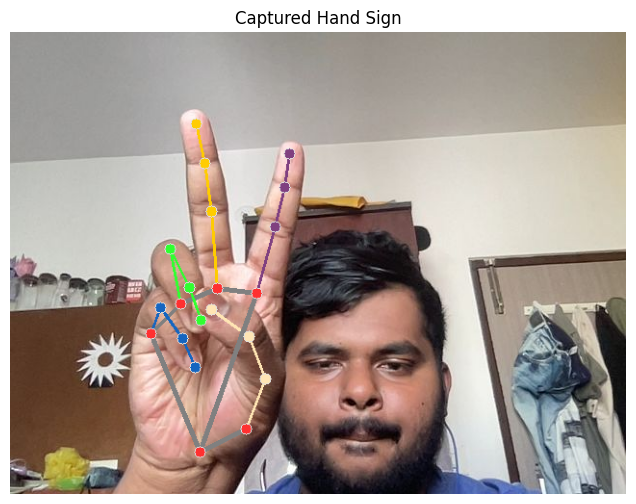


✅ Correct! You signed the number correctly! 🎉
You signed: 2
Confidence: 0.76

Explanation: Two plus zero equals two.

Continue to the next question? (yes/no): yes

Question 2 of 5

------------------------------------------------------------
📝 Question: What is the smallest single-digit number?
Please show the answer (0, 1, or 2) in ASL sign language.
------------------------------------------------------------

Please position your hand to show the answer in ASL.
Click 'Capture' when ready.



<IPython.core.display.Javascript object>

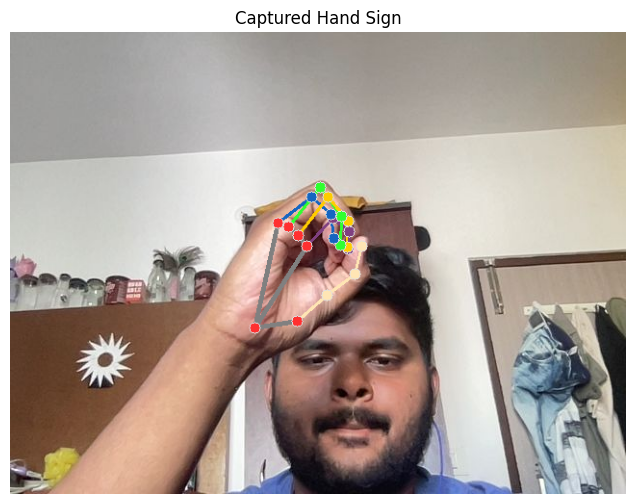


✅ Correct! You signed the number correctly! 🎉
You signed: 0
Confidence: 0.58

Explanation: Zero is the smallest single-digit number.

Continue to the next question? (yes/no): yes

Question 3 of 5

------------------------------------------------------------
📝 Question: How many noses does a person have?
Please show the answer (0, 1, or 2) in ASL sign language.
------------------------------------------------------------

Please position your hand to show the answer in ASL.
Click 'Capture' when ready.



<IPython.core.display.Javascript object>

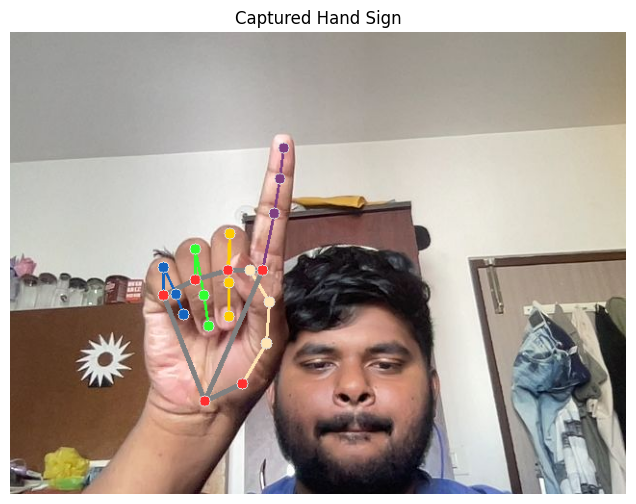


✅ Correct! You signed the number correctly! 🎉
You signed: 1
Confidence: 0.90

Explanation: People have one nose for breathing and smelling.

Continue to the next question? (yes/no): yes

Question 4 of 5

------------------------------------------------------------
📝 Question: What is 2 - 1?
Please show the answer (0, 1, or 2) in ASL sign language.
------------------------------------------------------------

Please position your hand to show the answer in ASL.
Click 'Capture' when ready.



<IPython.core.display.Javascript object>

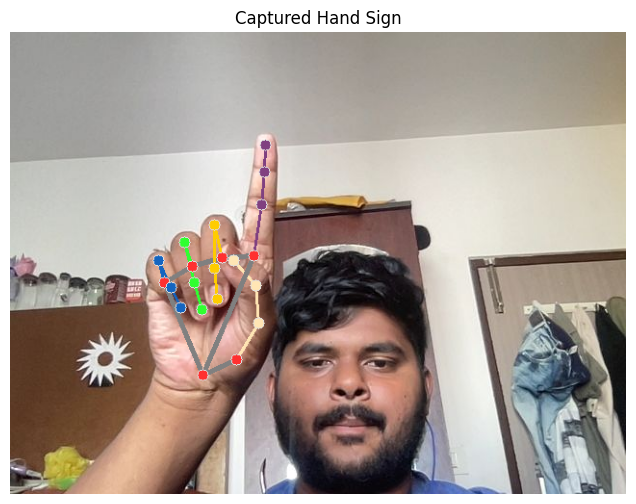


✅ Correct! You signed the number correctly! 🎉
You signed: 1
Confidence: 0.76

Explanation: Two minus one equals one.

Continue to the next question? (yes/no): no

Quiz completed! Your score: 4/4

Thank you for using EduSign AI Quiz System! Keep practicing your ASL!


In [79]:
# Cell 7: Run the Quiz System
# --------------------------------
def main():
    # Initialize the quiz system
    quiz_system = EduSignQuizSystem()

    # Setup the system (train or load model)
    quiz_system.setup_system()

    # Run the quiz
    num_questions = 5
    try:
        user_questions = input(f"How many questions would you like? (default: {num_questions}): ")
        if user_questions.strip():
            num_questions = int(user_questions)
    except:
        # Keep default if invalid input
        pass

    quiz_system.run_quiz(num_questions=num_questions)

# Run the main function
main()